In [2]:
# libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from pandas.plotting import scatter_matrix

import seaborn as sns
from datetime import datetime

import nltk
from nltk.corpus import stopwords
from textstat.textstat import textstat
from textatistic import Textatistic, textatistic
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

**EDA**

In [3]:
df = pd.read_csv("merged_data.csv", encoding="ISO-8859-1")

df.columns

Index(['text', 'user_id', 'in_reply_to_status_id', 'in_reply_to_user_id',
       'in_reply_to_screen_name', 'retweet_count', 'reply_count',
       'favorite_count', 'possibly_sensitive', 'num_hashtags', 'num_urls',
       'num_mentions', 'timestamp', 'class'],
      dtype='object')

In [4]:
df = df.drop('in_reply_to_status_id', axis=1)
df = df.drop('in_reply_to_user_id', axis=1)
df = df.drop('in_reply_to_screen_name', axis=1)

In [5]:
# Have to fill in zeros for rows that are supposed to have a 0 in the possibily_sensitive column. 

df['possibly_sensitive'].fillna(0, inplace=True)

In [6]:
df.head()

,text,user_id,retweet_count,reply_count,favorite_count,possibly_sensitive,num_hashtags,num_urls,num_mentions,timestamp,class
0,Y me dio un pollazo en el hombro,192193390,0,0,0,1.0,0,0,0,NaN,0
1,Amanecer sin saber que paso la noche anterior ...,192193390,0,0,0,1.0,0,0,0,NaN,0
2,Proximament videos WoW Mitst of PANDARIA!!!!,192193390,0,0,0,1.0,0,0,0,NaN,0
3,decido me lo voy a tatuar en el culo http://t....,192193390,0,1,0,0.0,0,0,0,NaN,0
4,recostrucccion del vlog ItsukiWTF QUE OS JODAN...,192193390,0,0,0,1.0,0,0,0,NaN,0


In [7]:
# parses tweet text 
# https://www.nltk.org/api/nltk.tokenize.html

tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [8]:
df["tokenized_text"] = df["text"].fillna("").map(nltk.word_tokenize)

In [9]:
# top 20 words (all accounts, all tweets, with puncuation)

top_N = 20
a = df['text'].str.cat(sep=' ')
words = tknzr.tokenize(a)
word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
rslt

,Word,Frequency
0,.,52148
1,",",34240
2,!,27528
3,-,26625
4,:,23763
5,"""",23263
6,?,22457
7,a,21532
8,the,21033
9,to,18755


In [10]:
# WILL USE REGEX FROM NOW ON, to ignore puncutation

# top 20 words (all accounts, without punucation)

tokenizer = RegexpTokenizer(r'\w+')

top_N = 20
a = df['text'].str.cat(sep=' ')
words = tokenizer.tokenize(a)
word_dist = nltk.FreqDist(words)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

rslt

# https://stackoverflow.com/questions/46786211/counting-the-frequency-of-words-in-a-pandas-data-frame

,Word,Frequency
0,http,29980
1,t,26260
2,a,21799
3,the,21078
4,co,20158
5,to,18777
6,I,16064
7,you,12392
8,RT,12369
9,of,11361


**Looking at all ~109,000 tweets, we can see that the majority are sending links or even retweeting**

Text(0.5,0.98,'Top 20 Words, All Accounts')

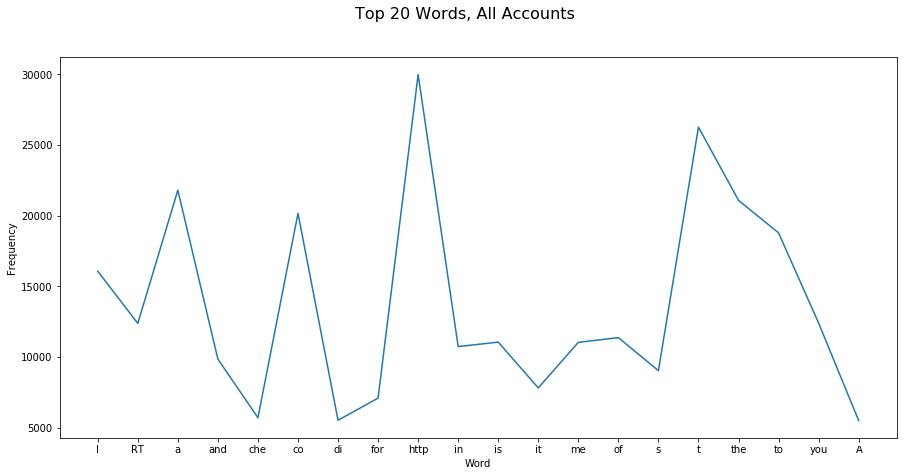

In [11]:
f, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x="Word", y="Frequency", data=rslt)
f.suptitle('Top 20 Words, All Accounts', fontsize = 16)

In [12]:
# bots (top 20, with stopwords)

bots = df[(df['class'] == 0)]

top_N = 20
a = bots['text'].str.cat(sep=' ')
words = tokenizer.tokenize(a)
word_dist = nltk.FreqDist(words)
rslt1 = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

rslt1

,Word,Frequency
0,http,23086
1,t,16828
2,a,16434
3,the,13729
4,co,13200
5,to,12458
6,I,9584
7,me,9446
8,you,8503
9,of,7729


**Bots tend to send links**

In [13]:
# bots (top 20, without stopwords)

bots = df[(df['class'] == 0)]

top_N = 20
a = bots['text'].str.cat(sep=' ')
allWords = tokenizer.tokenize(a)
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords) 

mostCommon= allWordExceptStopDist.most_common(top_N)

rslt2 = pd.DataFrame(mostCommon,
                    columns=['Word', 'Frequency'])

rslt2

,Word,Frequency
0,http,23086
1,co,13222
2,i,9584
3,la,6778
4,e,6142
5,che,6117
6,de,6074
7,di,5703
8,ã,5496
9,non,5065


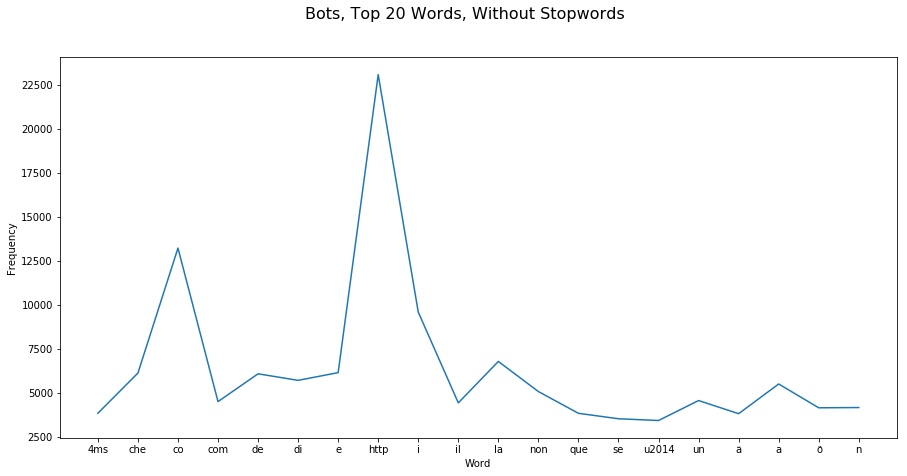

In [14]:
f, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x="Word", y="Frequency", data=rslt2)
f.suptitle('Bots, Top 20 Words, Without Stopwords', fontsize = 16);

In [15]:
# not bot (top 20, with stopwords)

bots = df[(df['class'] == 1)]

top_N = 20
a = bots['text'].str.cat(sep=' ')
words = tokenizer.tokenize(a)
word_dist = nltk.FreqDist(words)
rslt3 = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

rslt3

,Word,Frequency
0,t,9432
1,RT,9151
2,the,7349
3,co,6958
4,http,6894
5,I,6480
6,to,6319
7,a,5365
8,you,3889
9,of,3632


In [16]:
# not bot (top 20, without stopwords)

bots = df[(df['class'] == 1)]

top_N = 20
a = bots['text'].str.cat(sep=' ')
allWords = tokenizer.tokenize(a)
allWordDist = nltk.FreqDist(w.lower() for w in allWords)

stopwords = nltk.corpus.stopwords.words('english')
allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords) 

mostCommon= allWordExceptStopDist.most_common(top_N)

rslt4 = pd.DataFrame(mostCommon,
                    columns=['Word', 'Frequency'])
            
rslt4

,Word,Frequency
0,rt,9190
1,co,6972
2,http,6895
3,i,6480
4,â,3217
5,ã,3007
6,the,1132
7,like,1108
8,amp,949
9,one,872


**Here, we notice something interesting about the tweets from real users, they are retweeting more than sending links**

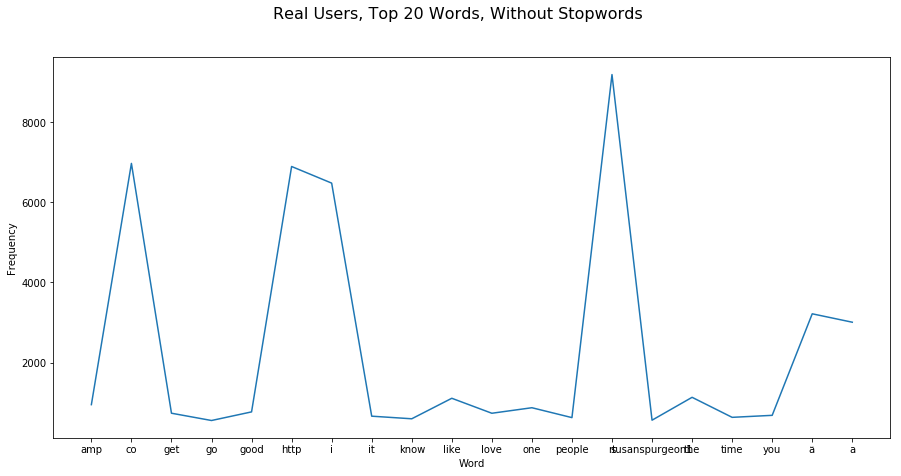

In [17]:
f, ax = plt.subplots(figsize=(15,7))
sns.lineplot(x="Word", y="Frequency", data=rslt4)
f.suptitle('Real Users, Top 20 Words, Without Stopwords', fontsize = 16);

In [18]:
# Calculate Flesch–Kincaid readability scores of the tweets

reading_score = []

for i in range(len(df)):
    try:
        score = textstat.flesch_reading_ease(df['text'][i])
        reading_score.append(abs(score))
    except TypeError:
        reading_score.append(100)    

Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of words are zero, cannot divide
Error(ASyPW): Number of word

In [19]:
reading_score = pd.DataFrame({'reading_score': reading_score})

In [20]:
df_new = pd.concat([df, reading_score], axis=1)

In [21]:
# https://github.com/shivam5992/textstat

not_bot = df_new[(df_new['class'] == 1)]
bot = df_new[(df_new['class'] == 0)]

print('Not Bot:', not_bot['reading_score'].mean())
print('Bot:', bot['reading_score'].mean())

Not Bot: 65.58820396381145
Bot: 64.86691318604488


In [22]:
# fleschman scale only goes up to 121.22. Adjust it so that happens

df_new['score_adjusted'] = df_new['reading_score'].apply(lambda x: 121 if x > 121.22 else x)

      Type      Score
0      Bot  63.675605
1  Not Bot  64.898310


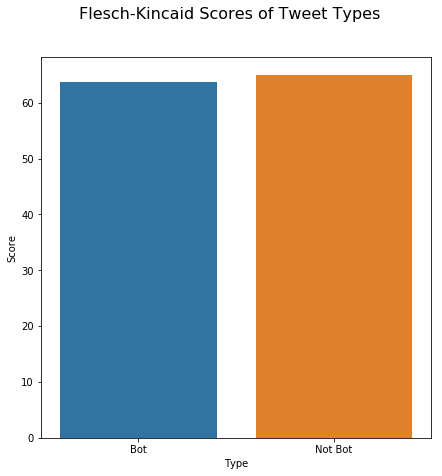

In [23]:
not_bot = df_new[(df_new['class'] == 1)]
bot = df_new[(df_new['class'] == 0)]

data = [['Bot', bot['score_adjusted'].mean()], ['Not Bot', not_bot['score_adjusted'].mean()]]

f_score = pd.DataFrame(data, columns=['Type', 'Score'])

f, ax = plt.subplots(figsize=(7,7))
f.suptitle('Flesch-Kincaid Scores of Tweet Types', fontsize = 16)
ax = sns.barplot(x='Type', y='Score', data=f_score)

print(f_score)

The Flesch-Kinaid score is a readability metric that uses a math formula to  score the complexitiy of the text. It is on a score between 0-100. For example, Time magazine would score a 52 and Harvard Law Review would be in the low 30s. 

100-90 = 5th grade

90-80 = 6th grade

80-70 = 7th grade

70-60 = 8th and 9th grade

60-50 = 10-12th grade

50-30 = college

30-0 = college grad (difficult to read)

In our case, the real users (not bot) have a slightly lower Flesch score, but statistically, they were very similar. We did not see a measurable difference between them.


https://en.wikipedia.org/wiki/Flesch–Kincaid_readability_tests

In [24]:
# word count of individual tweets

word_count = []
for i in range(len(df_new)):
    try:
        score = textatistic.word_count(df_new['text'][i])
        word_count.append(score)
    except AttributeError:
        word_count.append(1)

In [25]:
word_count = pd.DataFrame({'word_count': word_count})

In [26]:
df_new = pd.concat([df_new, word_count], axis=1)

In [27]:
not_bot = df_new[(df_new['class'] == 1)]
bot = df_new[(df_new['class'] == 0)]

print('Not Bot')
print("{:.3f} words +/- {:.3f}".format(not_bot['word_count'].mean(), not_bot['word_count'].std()))
print('----')
print('Bot')
print("{:.3f} words +/- {:.3f}".format(bot['word_count'].mean(), bot['word_count'].std()))

Not Bot
11.971 words +/- 7.067
----
Bot
11.819 words +/- 6.498


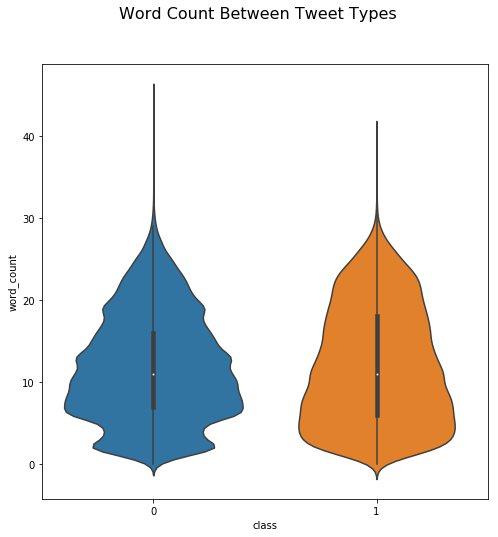

In [28]:
f, ax = plt.subplots(figsize=(8,8))
plt.suptitle('Word Count Between Tweet Types', fontsize = 16)
fig = sns.violinplot(x='class', y='word_count', data=df_new)
plt.show()

As we can see from the graph above, there is no measurable different between thw word count of real tweets and bot tweets. Even the distribution is similar.

**Some more EDA**

In [29]:
df_new.head()

,text,user_id,retweet_count,reply_count,favorite_count,possibly_sensitive,num_hashtags,num_urls,num_mentions,timestamp,class,tokenized_text,reading_score,score_adjusted,word_count
0,Y me dio un pollazo en el hombro,192193390,0,0,0,1.0,0,0,0,NaN,0,"[Y, me, dio, un, pollazo, en, el, hombro]",80.28,80.28,8
1,Amanecer sin saber que paso la noche anterior ...,192193390,0,0,0,1.0,0,0,0,NaN,0,"[Amanecer, sin, saber, que, paso, la, noche, a...",71.14,71.14,17
2,Proximament videos WoW Mitst of PANDARIA!!!!,192193390,0,0,0,1.0,0,0,0,NaN,0,"[Proximament, videos, WoW, Mitst, of, PANDARIA...",56.93,56.93,6
3,decido me lo voy a tatuar en el culo http://t....,192193390,0,1,0,0.0,0,0,0,NaN,0,"[decido, me, lo, voy, a, tatuar, en, el, culo,...",44.41,44.41,10
4,recostrucccion del vlog ItsukiWTF QUE OS JODAN...,192193390,0,0,0,1.0,0,0,0,NaN,0,"[recostrucccion, del, vlog, ItsukiWTF, QUE, OS...",37.98,37.98,8


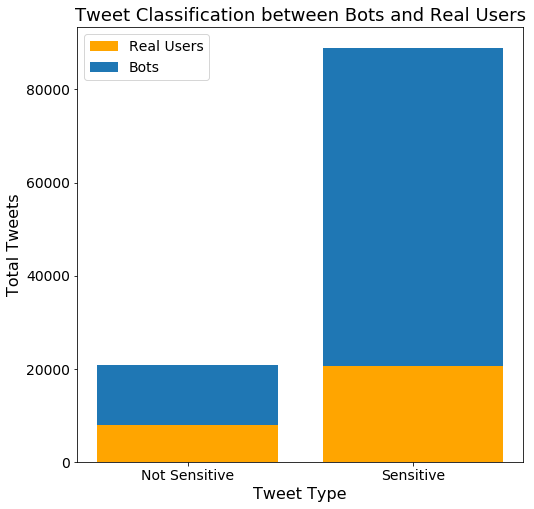

In [30]:
# possibly sensitive (bot vs not bot)

not_bot = df_new[(df_new['class'] == 1)]
bot = df_new[(df_new['class'] == 0)]

databot = [['0', len(not_bot[(not_bot['possibly_sensitive'] == 0)])], 
                ['1', len(not_bot[(not_bot['possibly_sensitive'] == 1)])]]
not_botdf = pd.DataFrame(databot, columns=['Type', 'Total'])

data = [['0', len(bot[(bot['possibly_sensitive'] == 0)])], 
                ['1', len(bot[(bot['possibly_sensitive'] == 1)])]]
botdf = pd.DataFrame(data, columns=['Type', 'Total'])


f, ax = plt.subplots(figsize=(8,8))
plt.title('Tweet Classification between Bots and Real Users', fontsize=18)
p1 = plt.bar(not_botdf['Type'], not_botdf['Total'], label='Real Users', color='orange')
p2 = plt.bar(botdf['Type'], botdf['Total'], bottom = not_botdf['Total'], label='Bots')
plt.xlabel('Tweet Type', fontsize=16);
plt.ylabel('Total Tweets', fontsize=16);
plt.xticks(botdf['Type'], ('Not Sensitive', 'Sensitive'), fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize=14);

Bots are posting higher proportions of sensitive data, compared to real users. 

-------

**NLP Machine Learning Model**

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# only using text and class data!
# class 0 = bot
# class 1 = real people

nlp_df = df_new[['class', 'text']].copy()

In [34]:
nlp_df.head()

,class,text
0,0,Y me dio un pollazo en el hombro
1,0,Amanecer sin saber que paso la noche anterior ...
2,0,Proximament videos WoW Mitst of PANDARIA!!!!
3,0,decido me lo voy a tatuar en el culo http://t....
4,0,recostrucccion del vlog ItsukiWTF QUE OS JODAN...


In [35]:
# stratified against classes, so data is equally represented (same proportions)

traindf, testdf = train_test_split(nlp_df, stratify=nlp_df['class'])

x_train = traindf['text']
x_test = testdf['text']
y_train = traindf['class']
y_test = testdf['class']

In [38]:
# fixed np.nan error
x_train = x_train.fillna(' ')
x_test = x_test.fillna(' ')

count_vect = CountVectorizer(stop_words='english')
x_train_modified = count_vect.fit_transform(x_train)
x_test_modified = count_vect.transform(x_test)

# TF-IDF

idf = TfidfTransformer()
fit2 = idf.fit(x_train_modified)
x_train_mod2 = fit2.transform(x_train_modified)

# MNB

mnb = MultinomialNB()
x_train_data = mnb.fit(x_train_mod2, y_train)

In [39]:
predicted = mnb.predict(x_test_modified)
val = accuracy_score(y_test, predicted)

print('Accuracy Score from MNB on Test Set:', val)

Accuracy Score from MNB on Test Set: 0.9199898029789868


------

**Using SKLearn's Pipeline Feature on Three Different Classifiers**

In [55]:
# using pipeline

ensemble_pipe = Pipeline([('cv', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer(use_idf=True)),
                   ('mnb', MultinomialNB(fit_prior=False)),
                    ])

ensemble_pipe.fit(x_train, y_train)
score = ensemble_pipe.predict(x_test)
val = accuracy_score(y_test, score)

print('Pipeline with MNB Classifier')
print('Accuracy Score on Training Set:', ensemble_pipe.score(x_train, y_train))
print('Accuracy Score on Test Set:', val)

Pipeline with MNB Classifier
Accuracy Score on Training Set: 0.9362913505311078
Accuracy Score on Test Set: 0.9166757711497141


In [48]:
# verification of score

accuracy = (y_test == score).mean()

print('Accuracy Score on Test Set:', accuracy)

Accuracy Score on Test Set: 0.9166757711497141


**Replaced MNB with SGDClassifier in pipeline, according to Sklearn docs, it is better than MNB**

Did not provide us with an improvement of the score, compared to MNB Classifier

In [114]:
# L1 (Lasso)
sgdc_pipe = Pipeline([('cv', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer(use_idf=True)),
                   ('sgdc', SGDClassifier(max_iter = 5, loss='hinge', penalty='l1'))])

sgdc_pipe.fit(x_train, y_train)
score = sgdc_pipe.predict(x_test)
val = accuracy_score(y_test, score)
print('Pipeline with SDGC Classifier (L1/Lasso)')
print('Accuracy Score on Training Set:', sgdc_pipe.score(x_train, y_train))
print('Accuracy Score on Test Set:', val)
print('\n')

# L2 (Ridge)
sgdc_pipe = Pipeline([('cv', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer(use_idf=True)),
                   ('sgdc', SGDClassifier(max_iter = 5, loss='hinge', penalty='l2'))])

sgdc_pipe.fit(x_train, y_train)
score = sgdc_pipe.predict(x_test)
val = accuracy_score(y_test, score)
print('Pipeline with SDGC Classifier (L2/Ridge)')
print('Accuracy Score on Training Set:', sgdc_pipe.score(x_train, y_train))
print('Accuracy Score on Test Set:', val)
print('\n')

# No penalty 
sgdc_pipe = Pipeline([('cv', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer(use_idf=True)),
                   ('sgdc', SGDClassifier(max_iter = 5, loss='hinge', penalty='none'))])

sgdc_pipe.fit(x_train, y_train)
score = sgdc_pipe.predict(x_test)
val = accuracy_score(y_test, score)
print('Pipeline with SDGC Classifier (No Penalty)')
print('Accuracy Score on Training Set:', sgdc_pipe.score(x_train, y_train))
print('Accuracy Score on Test Set:', val)

Pipeline with SDGC Classifier (L1/Lasso)
Accuracy Score on Training Set: 0.8599939301972686
Accuracy Score on Test Set: 0.8560399140536801


Pipeline with SDGC Classifier (L2/Ridge)
Accuracy Score on Training Set: 0.893608497723824
Accuracy Score on Test Set: 0.8816781383153065


Pipeline with SDGC Classifier (No Penalty)
Accuracy Score on Training Set: 0.9500091047040972
Accuracy Score on Test Set: 0.9206453257584034


**Replaced SGDC with Logistric Regression in pipeline**

In [69]:
logreg_pipe = Pipeline([('cv', CountVectorizer(stop_words='english')),
                 ('tfidf', TfidfTransformer(use_idf=True)),
                   ('logreg', LogisticRegression(solver='newton-cg'))])

logreg_pipe.fit(x_train, y_train)
score = logreg_pipe.predict(x_test)
val = accuracy_score(y_test, score)
print('Pipeline with Logistic Regression Classifier')
print('Accuracy Score on Training Set:', logreg_pipe.score(x_train, y_train))
print('Accuracy Score on Test Set:', val)

Pipeline with Logistic Regression Classifier
Accuracy Score on Training Set: 0.9417663125948407
Accuracy Score on Test Set: 0.9117593503040897


        Method     Score
0          MNB  0.916675
1    SGDC (L1)  0.855093
2    SGDC (L2)  0.880804
3  SGDC (None)  0.920062
4       LogReg  0.911759


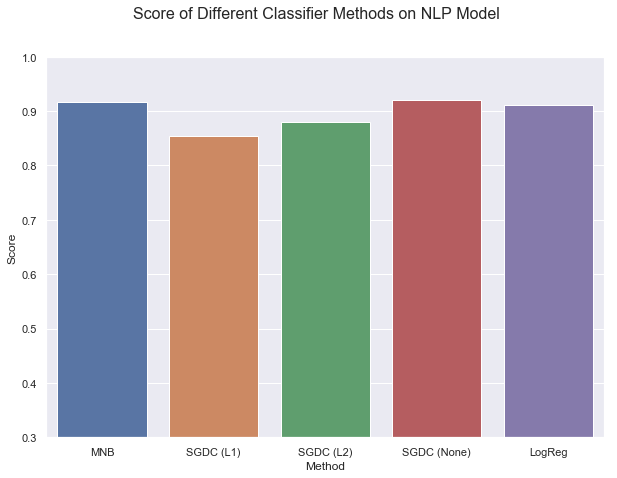

In [113]:
# graph comparing different methods on test set

data = [['MNB', 0.916675], ['SGDC (L1)', 0.855093], ['SGDC (L2)', 0.880804], 
            ['SGDC (None)', 0.920062], ['LogReg', 0.9117593]]

f_score = pd.DataFrame(data, columns=['Method', 'Score'])

f, ax = plt.subplots(figsize=(10,7))
f.suptitle('Score of Different Classifier Methods on NLP Model', fontsize = 16)
ax = sns.barplot(x='Method', y='Score', data=f_score)
plt.ylim(0.3, 1)

print(f_score)